In [1]:
pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 MB 102.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.0/583.0 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [albumentations]m [albumentations]eadless]
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import numpy as np

import PIL
from PIL import Image

import skimage
from skimage.io import imread
from skimage.transform import resize

import albumentations
import os
import math
import matplotlib.pyplot as plt
from glob import glob



print(torch.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.7.1+cu118
2.2.6
11.2.1
0.25.2
2.0.8


# Step 1. KITTI 데이터셋 수집과 구축

In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        size=(224, 224),
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                Resize(
                    width=224,
                    height=224
                    )
                ])

/tmp/ipykernel_132/2497950994.py:7: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop


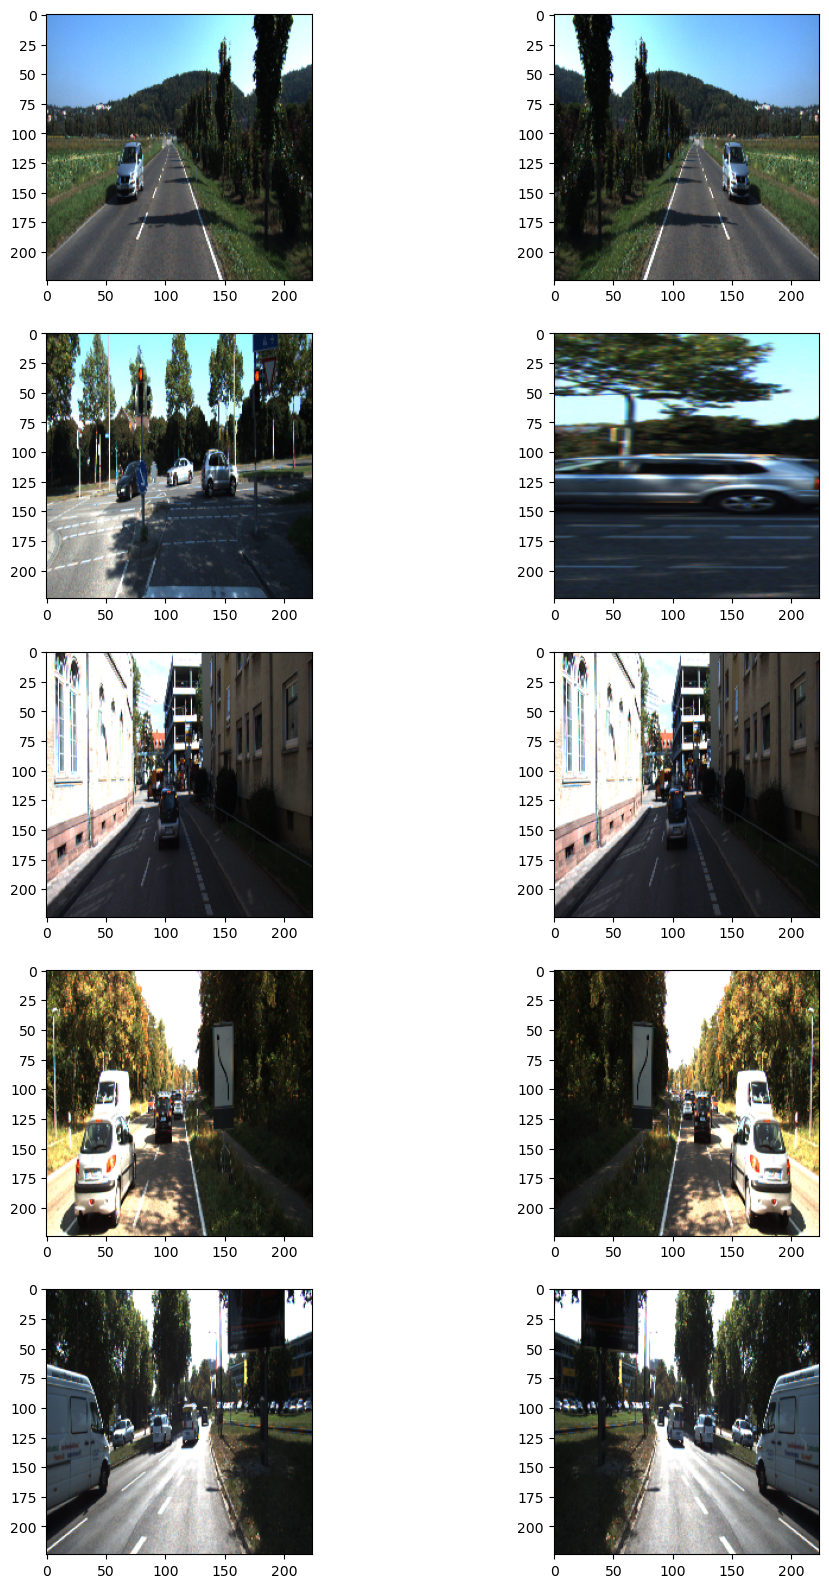

In [4]:
data_dir = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/data/training")

augmentation_train = build_augmentation()
augmentation_validation = build_augmentation(is_train=False)

input_images = glob(os.path.join(data_dir, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation_validation(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

In [5]:
from torch.utils.data import Dataset

class KittiDataset(Dataset):
    '''
    KittiDataset은 PyTorch의 Dataset을 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Dataset을 커스텀하여 사용합니다.
    '''
    def __init__(self,
                 dir_path,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Dataset이 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해 kitti dataset의 경로에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        input_images = sorted(glob(os.path.join(self.dir_path, "image_2", "*.png")))
        label_images = sorted(glob(os.path.join(self.dir_path, "semantic", "*.png")))

        assert len(input_images) == len(label_images)
        data = list(zip(input_images, label_images))

        if self.is_train:
            return data[:-10]
        return data[-10:]

    def __len__(self):
        # Dataset의 length로서 전체 dataset 크기를 반환합니다.
        return len(self.data)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize 및 augmentation이 적용된 input image이고
        # 출력은 semantic label입니다.
        input_img_path, output_path = self.data[index]

        _input = imread(input_img_path)
        _output = imread(output_path)

        # 특정 라벨을 이진 마스크로 변환
        # road에 대해서만 mask prediction
        _output = (_output == 7).astype(np.uint8) * 1

        data = {
            "image": _input,
            "mask": _output,
        }

        if self.augmentation:
            augmented = self.augmentation(**data)
            _input = augmented["image"] / 255.0  # Normalize
            _output = augmented["mask"]

        # 📌 target 차원 확장 (H, W) → (1, H, W)
        _output = np.expand_dims(_output, axis=0)

        return (
            torch.tensor(_input, dtype=torch.float32).permute(2, 0, 1),  # (H, W, C) → (C, H, W)
            torch.tensor(_output, dtype=torch.float32)  # (1, H, W) 형식 유지
        )

    def shuffle_data(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습 중인 경우에 데이터를 random shuffle합니다.
        if self.is_train:
            np.random.shuffle(self.data)

In [6]:
from torch.utils.data import DataLoader

# Augmentation 설정
augmentation = build_augmentation()
validation_preproc = build_augmentation(is_train=False)

train_dataset = KittiDataset(
    data_dir,
    augmentation=augmentation,
    is_train=True
)

validation_dataset = KittiDataset(
    data_dir,
    augmentation=validation_preproc,
    is_train=False
)


# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False)

/tmp/ipykernel_132/2497950994.py:7: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop


In [19]:
len(validation_dataset)

10

# Step 2-1-1. U-Net 모델의 구현

In [31]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(UNet, self).__init__()

        # Contracting Path (Encoder)
        self.enc1 = self.double_conv(input_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)
        self.dropout = nn.Dropout(0.5)

        # Expanding Path (Decoder)
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec9 = self.double_conv(128, 64)

        # Output layer
        self.final = nn.Conv2d(64, output_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        """2개의 Conv Layer로 이루어진 블록"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = self.pool1(c1)
        c2 = self.enc2(p1)
        p2 = self.pool2(c2)
        c3 = self.enc3(p2)
        p3 = self.pool3(c3)
        c4 = self.enc4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        c5 = self.bottleneck(p4)
        c5 = self.dropout(c5)

        # Decoder
        u6 = self.up6(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.dec6(u6)

        u7 = self.up7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.dec7(u7)

        u8 = self.up8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.dec8(u8)

        u9 = self.up9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.dec9(u9)

        # Output
        output = torch.sigmoid(self.final(c9))
        return output

# Step 2-2-1. U-Net 모델의 학습

In [12]:
def batch_calculate_iou_score(target, prediction):
    if target.shape != prediction.shape:
        prediction = resize(prediction, target.shape, mode='constant', preserve_range=True).astype(np.uint8)

    intersection = np.logical_and(target, prediction).sum(axis=(1,2)) # intersection을 구하는 코드를 작성해주세요.
    union = np.logical_or(target, prediction).sum(axis=(1,2)) # intersection을 구하는 코드를 작성해주세요.
    iou_scores = intersection / (union + 1e-7)  # iou 스코어를 구하되 결과값을 float로 만들어주세요!
    sum_iou = np.sum(iou_scores)
    return sum_iou

In [13]:
%%time

# 모델 저장 경로
model_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/seg_model_unet.pth")

# 모델 생성
model = UNet(input_channels=3, output_channels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 데이터로더 준비
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

# 모델 학습
num_epochs = 100
best_val_loss = 10000
patience = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    sum_iou = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())  # 타겟을 float 타입으로 변환
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        prediction = (outputs.detach().cpu().squeeze().numpy() > 0.5).astype(np.uint8)
        targets = (targets.detach().cpu().squeeze().numpy()).astype(np.uint8)

        sum_iou += batch_calculate_iou_score(targets, prediction)
        total += len(targets)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, mIoU: {sum_iou/total}")

    model.eval()
    with torch.no_grad():
        validation_running_loss = 0.0
        val_sum_iou = 0
        val_total = 0
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
    
            outputs = model(inputs)
            loss = criterion(outputs, targets.float())  # 타겟을 float 타입으로 변환
   
            validation_running_loss += loss.item()

            prediction = (outputs.detach().cpu().squeeze().numpy() > 0.5).astype(np.uint8)
            targets = (targets.detach().cpu().squeeze().numpy()).astype(np.uint8)
            val_sum_iou += batch_calculate_iou_score(targets, prediction)
            val_total += len(targets)
            
    val_loss = validation_running_loss/len(validation_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss}, mIoU: {val_sum_iou/val_total}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        print('Saving model')
        torch.save(model.state_dict(), model_path)
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


NameError: name 'UNet' is not defined

# Step 2-2-1. U-Net++ 모델의 구현

In [7]:
class ConvLayer(nn.Module):
    def __init__(self, in_dim, out_dim, conv_type=nn.Conv2d, norm_type=nn.BatchNorm2d, act_type=nn.LeakyReLU) -> None:
        super(ConvLayer, self).__init__()
        self.conv = nn.Sequential(
            conv_type(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            norm_type(out_dim),
            act_type()
        )
    def forward(self, inputs):
        return self.conv(inputs)

class ConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=None, num_conv=2) -> None:
        super(ConvBlock, self).__init__()
        if hidden_dim is None:
            hidden_dim = out_dim
        
        layers = []
        layers.append(ConvLayer(in_dim, hidden_dim))
        for _ in range(num_conv - 1):
            layers.append(ConvLayer(hidden_dim, out_dim))
        self.blocks = nn.Sequential(*layers)

    def forward(self, inputs):
        return self.blocks(inputs)

class UpsamplingLayer(nn.Module):
    def __init__(self, in_dim, out_dim, is_deconv=True, mode='bilinear') -> None:
        super(UpsamplingLayer, self).__init__()
        if is_deconv:
            self.upsampler = nn.ConvTranspose2d(in_dim, out_dim, kernel_size=2, stride=2)
        else:
            self.upsampler = nn.Sequential(
                nn.Upsample(scale_factor=2, mode=mode, align_corners=True),
                nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1)
            )
    def forward(self, x):
        return self.upsampler(x)

In [8]:
class SkipPathways(nn.Module):
    def __init__(self, in_dim, out_dim, lower_dim, path_length) -> None:
        super(SkipPathways, self).__init__()
        
        self.path_length = path_length
        self.conv_path = nn.ModuleList()
        self.upSamplers = nn.ModuleList()

        for j in range(1, path_length + 1):
            # 입력 채널 = (현재 행의 이전 노드들의 누적 채널) + (아래층에서 올라오는 채널)
            combined_dim = (out_dim * j) + out_dim 
            
            self.conv_path.append(ConvBlock(combined_dim, out_dim, num_conv=2))
            
            self.upSamplers.append(UpsamplingLayer(lower_dim, out_dim, is_deconv=True))

    def forward(self, x_i_0, lower_nodes):
        curr_row_nodes = [x_i_0]

        for j in range(self.path_length):
            # lower_nodes[j]는 항상 lower_dim 채널을 가지고 있습니다.
            up_low = self.upSamplers[j](lower_nodes[j])
            
            cat_feat = torch.cat(curr_row_nodes + [up_low], dim=1)
            out = self.conv_path[j](cat_feat)
            curr_row_nodes.append(out)

        return curr_row_nodes

In [9]:
class UNetpp(nn.Module):
    def __init__(self, num_classes=1, deep_supervision=True):
        super(UNetpp, self).__init__()
        self.deep_supervision = deep_supervision
        filters = [32, 64, 128, 256, 512]

        # 1. Encoder (X_0,0 ~ X_4,0)
        self.enc0_0 = ConvBlock(3, filters[0])
        self.enc1_0 = ConvBlock(filters[0], filters[1])
        self.enc2_0 = ConvBlock(filters[1], filters[2])
        self.enc3_0 = ConvBlock(filters[2], filters[3])
        self.enc4_0 = ConvBlock(filters[3], filters[4])
        self.pool = nn.MaxPool2d(2, 2)

        # 2. Skip Pathways (Nested Blocks)
        # 각 층별로 필요한 pathway 정의 (논문 L1, L2, L3, L4 구조)
        self.path0 = SkipPathways(filters[0], filters[0], filters[1], path_length=4)
        self.path1 = SkipPathways(filters[1], filters[1], filters[2], path_length=3)
        self.path2 = SkipPathways(filters[2], filters[2], filters[3], path_length=2)
        self.path3 = SkipPathways(filters[3], filters[3], filters[4], path_length=1)

        # 3. Deep Supervision Head
        self.final_convs = nn.ModuleList([
            nn.Conv2d(filters[0], num_classes, kernel_size=1) for _ in range(4)
        ])

    def forward(self, x):
        # Encoder & Downsampling
        x0_0 = self.enc0_0(x)
        x1_0 = self.enc1_0(self.pool(x0_0))
        x2_0 = self.enc2_0(self.pool(x1_0))
        x3_0 = self.enc3_0(self.pool(x2_0))
        x4_0 = self.enc4_0(self.pool(x3_0))

        # Nested Skip Pathways (밑에서부터 위로 계산하며 올라옴)
        # j=1, 2, 3, 4 순서로 노드들이 생성됨
        x3_list = self.path3(x3_0, [x4_0])
        x2_list = self.path2(x2_0, x3_list)
        x1_list = self.path1(x1_0, x2_list)
        x0_list = self.path0(x0_0, x1_list)

        # Deep Supervision (X0,1, X0,2, X0,3, X0,4의 결과 사용)
        outputs = [self.final_convs[i](x0_list[i+1]) for i in range(4)]

        if self.deep_supervision:
            return torch.sigmoid(sum(outputs) / len(outputs))
        else:
            return torch.sigmoid(outputs[-1])

- This is because polyps and liver appear at varying scales in video frames and CT slices; and thus, a multi-scale approach using all segmentation branches (deep
supervision) is essential for accurate segmentation. 
- Deep supervision also enables more accurate segmentation particularly for lesions that appear at multiple scales such as polyps in colonoscopy videos.

# Step 2-2-1. U-Net++ 모델의 학습

In [10]:
import torch.nn.functional as F

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        bce = F.binary_cross_entropy_with_logits(input, target)
        smooth = 1e-5
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice

In [14]:
%%time

# 모델 저장 경로
model_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/seg_model_unetpp.pth")

# 모델 생성
model = UNetpp(num_classes=1, deep_supervision=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수 및 옵티마이저 설정
#criterion = torch.nn.BCELoss()
criterion = BCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 데이터로더 준비
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

# 모델 학습
num_epochs = 100
best_val_loss = 10000
patience = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    sum_iou = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())  # 타겟을 float 타입으로 변환
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        prediction = (outputs.detach().cpu().squeeze().numpy() > 0.5).astype(np.uint8)
        targets = (targets.detach().cpu().squeeze().numpy()).astype(np.uint8)

        sum_iou += batch_calculate_iou_score(targets, prediction)
        total += len(targets)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, mIoU: {sum_iou/total}")

    model.eval()
    with torch.no_grad():
        validation_running_loss = 0.0
        val_sum_iou = 0
        val_total = 0
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
    
            outputs = model(inputs)
            loss = criterion(outputs, targets.float())  # 타겟을 float 타입으로 변환
   
            validation_running_loss += loss.item()

            prediction = (outputs.detach().cpu().squeeze().numpy() > 0.5).astype(np.uint8)
            targets = (targets.detach().cpu().squeeze().numpy()).astype(np.uint8)
            val_sum_iou += batch_calculate_iou_score(targets, prediction)
            val_total += len(targets)
            
    val_loss = validation_running_loss/len(validation_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss}, mIoU: {val_sum_iou/val_total}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        print('Saving model')
        torch.save(model.state_dict(), model_path)
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


Epoch 1/100, Loss: 1.0624648531277974, mIoU: 0.447700693788202
Epoch 1/100, Val Loss: 1.038529872894287, mIoU: 0.2762098685209707
Saving model
Epoch 2/100, Loss: 1.076384757955869, mIoU: 0.48126449244704983
Epoch 2/100, Val Loss: 1.0372273921966553, mIoU: 0.3024098352612507
Saving model
Epoch 3/100, Loss: 1.0420298178990681, mIoU: 0.5758417346053835
Epoch 3/100, Val Loss: 1.006335973739624, mIoU: 0.42912034105812913
Saving model
Epoch 4/100, Loss: 1.0291105508804321, mIoU: 0.6387810636884717
Epoch 4/100, Val Loss: 0.9558718800544739, mIoU: 0.5895442792243408
Saving model
Epoch 5/100, Loss: 1.0372787564992905, mIoU: 0.6367067063135158
Epoch 5/100, Val Loss: 0.9475179314613342, mIoU: 0.6169109238130426
Saving model
Epoch 6/100, Loss: 1.0341430008411407, mIoU: 0.6602935467388179
Epoch 6/100, Val Loss: 0.953362762928009, mIoU: 0.5893630445241845
Epoch 7/100, Loss: 1.030822401245435, mIoU: 0.6484180443330523
Epoch 7/100, Val Loss: 0.9452801942825317, mIoU: 0.6052022624678666
Saving model
Ep

# Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

In [32]:
model = UNet()
#model = UNetpp(num_classes=1, deep_supervision=True)
model_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/seg_model_unet.pth")

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()  # 평가 모드로 전환

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4): Sequential(
    (0): Con

In [16]:
def calculate_iou_score(target, prediction):
    if target.shape != prediction.shape:
        prediction = resize(prediction, target.shape, mode='constant', preserve_range=True).astype(np.uint8)

    intersection = np.logical_and(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    union = np.logical_or(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    iou_score = intersection / (union + 1e-7)  # iou 스코어를 구하되 결과값을 float로 만들어주세요!
    print(f"IoU : {iou_score:.6f}")
    return iou_score

In [17]:
import matplotlib.pyplot as plt
def get_output(model, preproc, image_path, output_path, label_path=None):
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32)
    input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    prediction = (output[0].squeeze().numpy() > 0.5).astype(np.uint8) * 255
    prediction = Image.fromarray(prediction).convert('L')

    background = Image.fromarray(origin_img).convert('RGBA')
    plt.imshow(background)
    plt.axis('off')  # 축 제거 (옵션)
    plt.show()
    prediction_resized = prediction.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    blended = Image.blend(background, prediction_resized, alpha=0.5)

    blended.save(output_path)
    # PIL 객체를 numpy로 변환
    img_np = np.array(blended)

    # 시각화
    plt.imshow(img_np)
    plt.axis('off')  # 축 제거 (옵션)
    plt.show()

    target = None
    if label_path:
        label_img = imread(label_path)
        label_data = {"image": label_img}
        label_processed = preproc(**label_data)["image"]
        target = (label_processed == 7).astype(np.uint8) * 1

    return blended, np.array(prediction), target

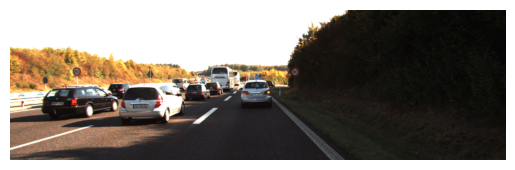

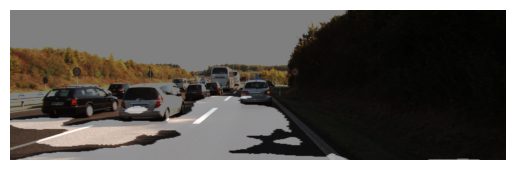

IoU : 0.642390


np.float64(0.6423896008053619)

In [27]:
result_dir = os.path.join(os.getenv("HOME"), "work/AIFFEL_quest_rs/GoingDeeper/Deeper03")
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
# test set에 대한 label을 모르기에 training set의 sample에 대하여 iou 계산
i = 199    # i값을 바꾸면 테스트용 파일이 달라집니다.
output, prediction, target = get_output(
     model,
     validation_preproc,
     image_path=data_dir + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=result_dir + f'/result_unetpp_{str(i).zfill(3)}.png',
     label_path=data_dir + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

In [28]:
import matplotlib.pyplot as plt

def get_output(model, preproc, image_path, output_path):
    # 원본 이미지 로드
    origin_img = imread(image_path)
    data = {"image": origin_img}

    # 전처리 적용
    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

    # 모델 추론 (inference)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    # 시그모이드 활성화 후 임계값(0.5) 적용하여 바이너리 마스크 생성
    output = (output[0].squeeze().numpy() > 0.5).astype(np.uint8) * 255   #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)

    # 배경과 결합하여 시각화 (Overlay)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    blended = Image.blend(background, output, alpha=0.5)
 
    plt.imshow(output)
    plt.axis('off')  # 축 제거 (옵션)
    plt.show()

    # 변환된 이미지 저장
    blended.save(output_path)

    # PIL 객체를 numpy로 변환
    img_np = np.array(blended)

    # 시각화
    plt.imshow(img_np)
    plt.axis('off')  # 축 제거 (옵션)
    plt.show()

    # blended.show()
    return blended

## Test set: UNet

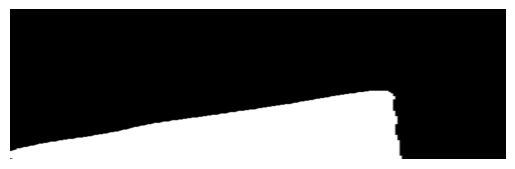

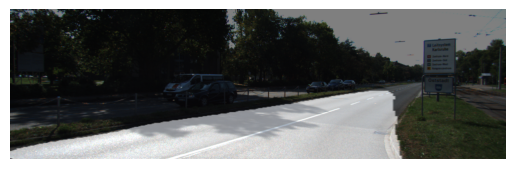

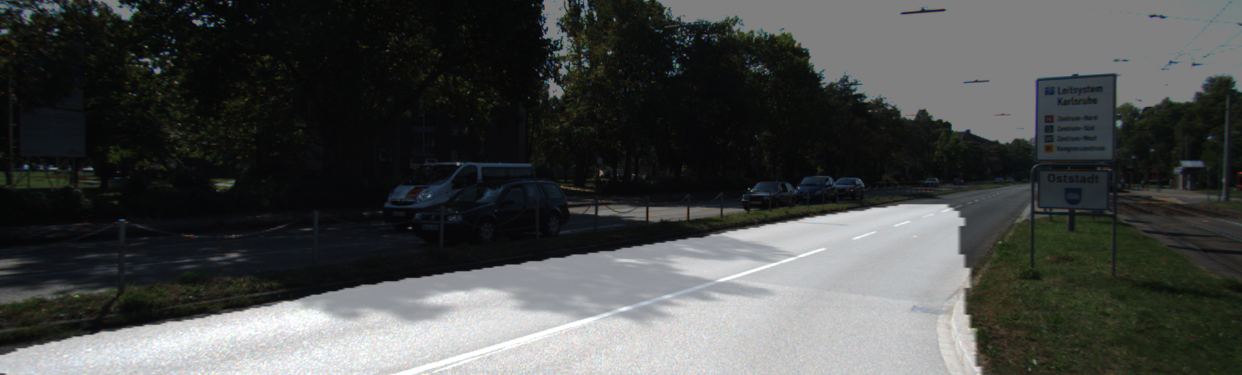

In [33]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
test_data_dir = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/data/testing")
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.
get_output(
     model,
     validation_preproc,
     image_path=test_data_dir + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=test_data_dir + f'/result_test_unet_{str(i).zfill(3)}.png'
 )

## Test set: UNet++

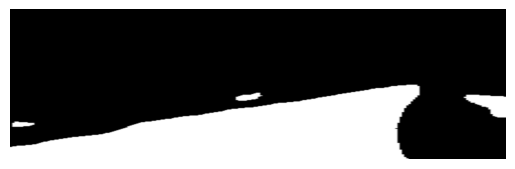

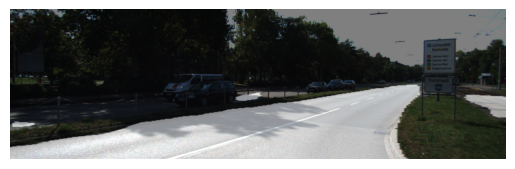

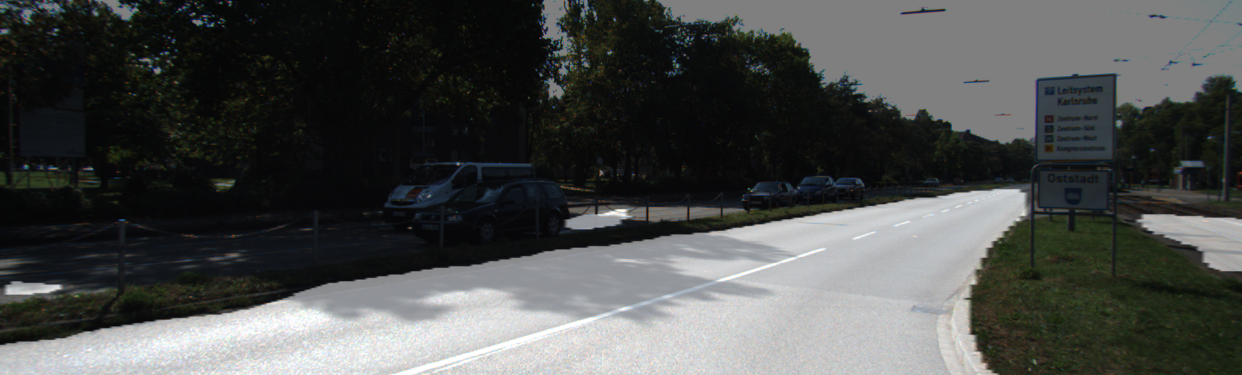

In [30]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
test_data_dir = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/data/testing")
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.
get_output(
     model,
     validation_preproc,
     image_path=test_data_dir + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=test_data_dir + f'/result_test_unetpp_{str(i).zfill(3)}.png'
 )

## 회고

- 별도로 마련한 validation set 기준으로 UNet은 0.7033 UNet++은 0.7308 IoU 성능을 보였다.
- Test set으로 masked 영역을 살펴보았을 때 UNet은 도로가 휘어지는 구간이나 작은 도로 영역을 탐지하지 못 하는 반면에 UNet++은 꺾여진 도로와 작은 도로 영역을 비교적 잘 masking 하는 것을 확인할 수 있었다.
- 도로의 경계선 영역까지 세밀하게 segmentation 하기 위해서 Boundary loss (surface loss)를 추가해 볼 수 있다. [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032) 논문에서는 정답 영역의 경계선으로부터 각 픽셀이 얼마나 떨어져 있는지를 weight로 반영하여 penarlity를 부여하는 방식이다. 이를 통해 실제 경계선과 가깝게 masking 하도록 유도할 수 있을 것이다.